100.0%
100.0%
100.0%
100.0%


Total training samples: 60000
Batch shape: torch.Size([8, 1, 28, 28])
Labels: [3, 7, 5, 3, 6, 5, 4, 5]


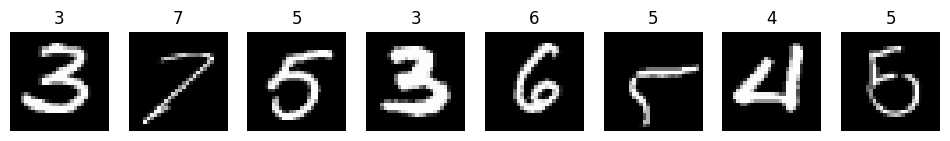

In [2]:
# --- Simple Data Loader Test (MNIST) ---

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

#  Define a basic transform
transform = transforms.Compose([
    transforms.ToTensor()
])

#Load MNIST dataset (auto-downloads if not present)
train_dataset = datasets.MNIST(root="../data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

# heck dataset size
print(f"Total training samples: {len(train_dataset)}")

# Fetch one batch
images, labels = next(iter(train_loader))

print("Batch shape:", images.shape)
print("Labels:", labels.tolist())

#Visualize a few images
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axes[i].imshow(images[i].squeeze(), cmap="gray")
    axes[i].set_title(str(labels[i].item()))
    axes[i].axis("off")
plt.show()


In [1]:
pip install torch torchvision torchaudio matplotlib


  Using cached matplotlib-3.10.7-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.10.0-py3-none-any.whl.metadata (10 kB)
  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached pillow-12.0.0-cp310-cp310-win_amd64.whl.metadata (9.0 kB)
  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp310-cp310-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp310-cp310-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached markupsafe-3.0.3-cp310-c

Running on device: cpu


100.0%
100.0%
100.0%
100.0%


Loaded MNIST ✔️ — 60000 training samples
Batch shape: torch.Size([64, 1, 28, 28]), Labels: [7, 7, 5, 2, 3, 5, 4, 6]
Epoch [1/3]  Loss: 0.3845  Accuracy: 93.96%
Epoch [2/3]  Loss: 0.1776  Accuracy: 94.89%
Epoch [3/3]  Loss: 0.1332  Accuracy: 96.37%
✅ Saved experiment in: experiments\exp_01_baseline


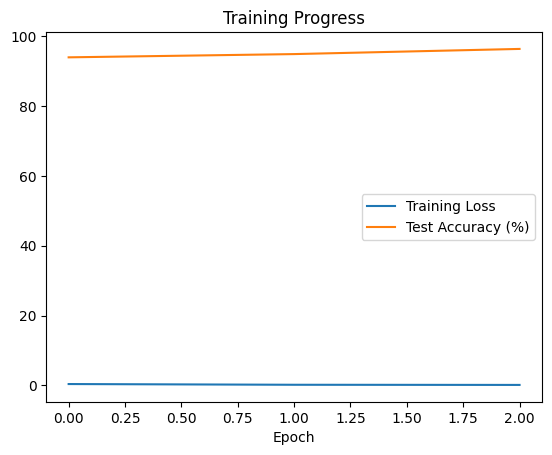

In [3]:
# =======================================================================
# 🧠 Exploring Model Performance — Single File Experiment
# Dataset: MNIST (built-in)
# =======================================================================

import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ---------------------------
# 1️⃣ Dataset Loading
# ---------------------------
def get_mnist_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # quick peek
    images, labels = next(iter(train_loader))
    print(f"Loaded MNIST ✔️ — {len(train_data)} training samples")
    print(f"Batch shape: {images.shape}, Labels: {labels[:8].tolist()}")
    return train_loader, test_loader

# ---------------------------
# 2️⃣ Model Definition
# ---------------------------
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ---------------------------
# 3️⃣ Evaluation
# ---------------------------
def evaluate_model(model, test_loader, device="cpu"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    return acc

# ---------------------------
# 4️⃣ Training Loop
# ---------------------------
def train_model(train_loader, test_loader, lr=0.001, epochs=3, device="cpu"):
    model = SimpleNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses, accs = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        acc = evaluate_model(model, test_loader, device)
        losses.append(avg_loss)
        accs.append(acc)
        print(f"Epoch [{epoch+1}/{epochs}]  Loss: {avg_loss:.4f}  Accuracy: {acc:.2f}%")

    return model, losses, accs

# ---------------------------
# 5️⃣ Save Experiment
# ---------------------------
def save_experiment(model, metrics, exp_name="exp_01_baseline"):
    os.makedirs("experiments", exist_ok=True)
    exp_dir = os.path.join("experiments", exp_name)
    os.makedirs(exp_dir, exist_ok=True)

    torch.save(model.state_dict(), os.path.join(exp_dir, "model.pth"))
    with open(os.path.join(exp_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=4)
    print(f"✅ Saved experiment in: {exp_dir}")

# ---------------------------
# 6️⃣ Run the Experiment
# ---------------------------
def run_experiment():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Running on device: {device}")

    train_loader, test_loader = get_mnist_loaders(batch_size=64)
    model, losses, accs = train_model(train_loader, test_loader, lr=0.001, epochs=3, device=device)

    metrics = {"losses": losses, "accuracies": accs}
    save_experiment(model, metrics)

    # quick visual summary
    plt.plot(losses, label="Training Loss")
    plt.plot(accs, label="Test Accuracy (%)")
    plt.legend()
    plt.title("Training Progress")
    plt.xlabel("Epoch")
    plt.show()

# ---------------------------
# 7️⃣ Execute
# ---------------------------
if __name__ == "__main__":
    run_experiment()


In [1]:
# ---------------------------
# 1️⃣ Dataset Loading
# ---------------------------
def get_mnist_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # quick peek
    images, labels = next(iter(train_loader))
    print(f"Loaded MNIST ✔️ — {len(train_data)} training samples")
    print(f"Batch shape: {images.shape}, Labels: {labels[:8].tolist()}")
    return train_loader, test_loader

In [ ]:

# ---------------------------
# 2️⃣ Model Definition
# ---------------------------
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
# ---------------------------
# 3️⃣ Evaluation
# ---------------------------
def evaluate_model(model, test_loader, device="cpu"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    return acc


In [ ]:
# ---------------------------
# 4️⃣ Training Loop
# ---------------------------
def train_model(train_loader, test_loader, lr=0.001, epochs=3, device="cpu"):
    model = SimpleNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses, accs = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        acc = evaluate_model(model, test_loader, device)
        losses.append(avg_loss)
        accs.append(acc)
        print(f"Epoch [{epoch+1}/{epochs}]  Loss: {avg_loss:.4f}  Accuracy: {acc:.2f}%")

    return model, losses, accs


In [ ]:
# ---------------------------
# 5️⃣ Save Experiment
# ---------------------------
def save_experiment(model, metrics, exp_name="exp_01_baseline"):
    os.makedirs("experiments", exist_ok=True)
    exp_dir = os.path.join("experiments", exp_name)
    os.makedirs(exp_dir, exist_ok=True)

    torch.save(model.state_dict(), os.path.join(exp_dir, "model.pth"))
    with open(os.path.join(exp_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=4)
    print(f"✅ Saved experiment in: {exp_dir}")

In [ ]:
# ---------------------------
# 6️⃣ Run the Experiment
# ---------------------------
def run_experiment():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Running on device: {device}")

    train_loader, test_loader = get_mnist_loaders(batch_size=64)
    model, losses, accs = train_model(train_loader, test_loader, lr=0.001, epochs=3, device=device)

    metrics = {"losses": losses, "accuracies": accs}
    save_experiment(model, metrics)

    # quick visual summary
    plt.plot(losses, label="Training Loss")
    plt.plot(accs, label="Test Accuracy (%)")
    plt.legend()
    plt.title("Training Progress")
    plt.xlabel("Epoch")
    plt.show()


In [ ]:
# ---------------------------
# 7️⃣ Execute
# ---------------------------
if __name__ == "__main__":
    run_experiment()